# Example Notebook for Downloading CDEC Snow Depth Data  
#### **Created by Hannah Besso**, July 2023  

### This notebook does the following:  
* Load a region of interest
* Make a geodataframe of the coordinates of all CDEC stations within the roi
* Make a dataframe of snow depth data from a single CDEC station
* Make a dataframe containing snow depth data from all CDEC stations within the roi
* Convert from inches to meters and plot the timeseries of one station

### Import necessary packages

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.variables import CdecStationVariables

### Load USA states:

In [2]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
california = states_gdf.loc[states_gdf.NAME == 'California']

In [3]:
from shapely.geometry import Polygon

coords = [(-120.03380085114448,38.2593960348446),
          (-120.03380085114448,36.934834847980355),
          (-118.1903872978364,36.934834847980355),
          (-118.1903872978364,38.2593960348446),
          (-120.03380085114448,38.2593960348446)]

polygon = Polygon(coords)

central_sierra = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])

### Access a geodataframe of CDEC station locations:  
Using the California polygon to get a list of all stations, excluding snow courses

In [4]:
vrs = [
#    CdecStationVariables.SWE      # I want snow depth but SWE is also available
    CdecStationVariables.SNOWDEPTH
]
points = CDECPointData.points_from_geometry(central_sierra, vrs, snow_courses=False)
cdec_locations = points.to_dataframe()
cdec_locations.set_crs('epsg:4326')
cdec_locations.head()

,name,id,datasource,geometry
0,SAWMILL,SWM,CDEC,POINT Z (-118.56259 37.16196 10200.00000)
1,MERCED LAKE,MLK,CDEC,POINT Z (-119.40572 37.73855 7300.00000)
2,GIANELLI MEADOW,GNL,CDEC,POINT Z (-119.89319 38.20431 8400.00000)
3,VOLCANIC KNOB,VLC,CDEC,POINT Z (-118.90504 37.38786 10050.00000)
4,BISHOP PASS,BSH,CDEC,POINT Z (-118.55700 37.10000 11200.00000)


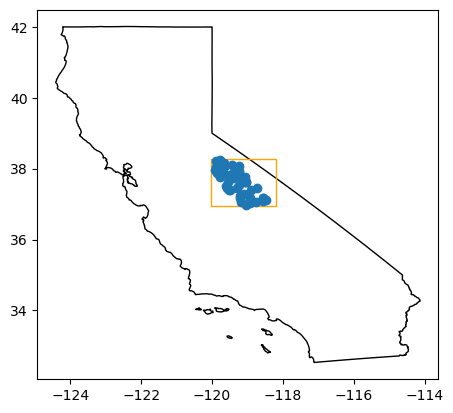

In [5]:
fig, ax = plt.subplots()

california.plot(facecolor='none', edgecolor='k', ax=ax)
central_sierra.plot(facecolor='none', edgecolor='orange', ax=ax)
cdec_locations.plot(ax=ax);

### Download snow depth data for a single CDEC station:

In [6]:
start_date = datetime(2020,10,1)
end_date = datetime(2023,7,31)

In [7]:
# Download data for TUM to get the datetime index:
cdec_point = CDECPointData("TUM", "TUM")
tum_depth = cdec_point.get_daily_data(
    start_date, end_date,
    [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH]
)
tum_depth.head()

,,geometry,SNOWDEPTH,SNOWDEPTH_units,datasource
datetime,site,,,,
2020-10-01 08:00:00+00:00,TUM,POINT Z (-119.34810 37.87641 8600.00000),0.0,INCHES,CDEC
2020-10-02 08:00:00+00:00,TUM,POINT Z (-119.34810 37.87641 8600.00000),0.0,INCHES,CDEC
2020-10-03 08:00:00+00:00,TUM,POINT Z (-119.34810 37.87641 8600.00000),0.0,INCHES,CDEC
2020-10-04 08:00:00+00:00,TUM,POINT Z (-119.34810 37.87641 8600.00000),1.0,INCHES,CDEC
2020-10-05 08:00:00+00:00,TUM,POINT Z (-119.34810 37.87641 8600.00000),0.0,INCHES,CDEC


### Create a dataframe of snow depth data from every CDEC station within the ROI:

In [8]:
# Reindex from a multiindex so I can easily access the datetime index:
tum_depth = tum_depth.reset_index()
tum_depth = tum_depth.set_index('datetime')

# Create a new empty dataframe with the TUM datetime index:
snwd_df = pd.DataFrame()
snwd_df.index = pd.DatetimeIndex(data=tum_depth.index)

# Iteratively download all the data and add the SNOWDEPTH column to the snwd_df:
# Note that the snow depth unit is inches
for i in range(len(cdec_locations)):
    cdec_point = CDECPointData(cdec_locations.id.values[i], cdec_locations.id.values[i])
    cdec_depth = cdec_point.get_daily_data(
        start_date, end_date,
        [cdec_point.ALLOWED_VARIABLES.SNOWDEPTH]
    )
    if cdec_depth is not None:
        cdec_depth = cdec_depth.reset_index()
        cdec_depth = cdec_depth.set_index('datetime')
        snwd_df[f'{cdec_locations.id.values[i]}'] = cdec_depth['SNOWDEPTH']
    else:
        continue

In [9]:
snwd_df.head()

,SWM,MLK,GNL,VLC,BSH,REL,DAN,UBC,DPO,CHM,...,GYP,BCB,KUB,JMW,TNY,VRG,GRM,GEM,TES,HRS
datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-01 08:00:00+00:00,0.0,64.750000,1.0,1.0,NaN,0.0,0.0,NaN,1.0,1.0,...,-0.208333,0.0,0.0,0.142857,-1.0,NaN,NaN,NaN,-1.0,NaN
2020-10-02 08:00:00+00:00,3.0,65.458333,1.0,2.0,NaN,0.0,0.0,NaN,1.0,1.0,...,-0.208333,0.0,0.0,0.500000,-1.0,NaN,NaN,NaN,0.0,NaN
2020-10-03 08:00:00+00:00,0.0,56.666667,0.0,2.0,NaN,0.0,0.0,NaN,1.0,1.0,...,-0.208333,0.0,0.0,1.444444,0.0,NaN,NaN,NaN,0.0,NaN
2020-10-04 08:00:00+00:00,0.0,40.208333,1.0,1.0,NaN,0.0,0.0,NaN,1.0,1.0,...,0.000000,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,1.0,NaN
2020-10-05 08:00:00+00:00,3.0,47.333333,1.0,1.0,NaN,0.0,0.0,NaN,1.0,1.0,...,-0.250000,0.0,0.0,0.076923,0.0,NaN,NaN,NaN,0.0,NaN


In [10]:
# convert from inches to meters
snwd_df_m = snwd_df * 0.0254

Text(0, 0.5, 'Snow Depth (m)')

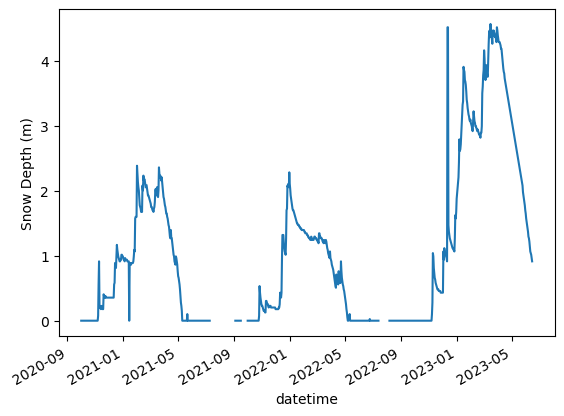

In [11]:
fig, ax = plt.subplots()

snwd_df_m['DAN'].plot(ax=ax)
ax.set_ylabel('Snow Depth (m)')